In [1]:
import tensorflow as tf
from tensorflow.contrib import rnn
import matplotlib.pyplot as plt    
import pandas as pd                   
import numpy as np                    
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


In [2]:
def CSVread(file, variables):
    ''' CSV Format 파일 읽기 '''
    data = pd.read_csv(file, delimiter=',', 
                       na_values=['NAN'], header=0,
                       engine='python',
                       usecols=variables)
    return data


In [3]:
def MinMaxScaler(data):
    ''' Min Max Normalization
    References : 
    http://sebastianraschka.com/Articles/2014_about_feature_scaling.html
    '''
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)

def FindMinMax(data):
    ''' Find Minimum & Maximum value '''
    Mindata = np.min(data, 0)
    Maxdata = np.max(data, 0)
    return Mindata, Maxdata

def MinMaxReturn(val, Min, Max):
    ''' Return normalized data '''
    return val * (Max - Min + 1e-7) + Min

def getStartEnd(startDate, endDate, time):
    ''' 특정 계절에 대한 시작/끝 인덱스'''
    start, end = 1, 1
    for idx in range(len(time)):  
        #print(time[idx])
        if time[idx] == startDate: 
            start = idx
        if time[idx] == endDate:
            end = idx
    return [start, end]


In [4]:
def Model(x, y, summerLength, seq_length, iterations):
    ''' Main model '''
    dataX, dataY = [], []
    for i in range(0, summerLength - seq_length - 1):
        size = i + seq_length
        _x = x[i : size] 
        _y = y[size : size + predict_length] 
        dataX.append(_x)
        dataY.append(_y)
    dataX = np.array(dataX)
    dataY = np.array(dataY)
    
    # train/test split
    train_size = int(len(dataY) * 0.8)
    trainX  = np.array(dataX[ : train_size])
    testX   = np.array(dataX[train_size : ])
    trainY  = np.array(dataY[ : train_size]) 
    testY   = np.array(dataY[train_size : ]) 
     
    # input place holders
    X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
    Y = tf.placeholder(tf.float32, [None, 1])

    cell = tf.contrib.rnn.BasicLSTMCell(num_units = hidden_dim, 
                                        state_is_tuple = True, 
                                        activation = tf.tanh)
    def lstm_cell():
        ''' Use LSTM model '''
        cell = rnn.BasicLSTMCell(hidden_dim, state_is_tuple=True) 
        return cell
    
    cell = tf.contrib.rnn.BasicLSTMCell(
        num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
    outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype = tf.float32)
    Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, 
                                               activation_fn = None)
    
    # cost/loss
    loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
    # optimizer
    optimizer = tf.train.RMSPropOptimizer(learning_rate)
    train = optimizer.minimize(loss)
    
    # RMSE
    targets = tf.placeholder(tf.float32, [None, 1])
    predictions = tf.placeholder(tf.float32, [None, 1])
    rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))
    
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)

        # Training step    
        for i in range(iterations):
            _  ,cost = sess.run([train ,loss], 
                                 feed_dict={X: trainX, Y: trainY})
            if (i+1) % (iterations/20) == 0:
                print("[step: {}] loss: {}".format(i+1, cost))
        #train_predict = sess.run(Y_pred, feed_dict={X: trainX})
        test_predict = sess.run(Y_pred, feed_dict={X: testX})
        rmse_val = sess.run(rmse, feed_dict={
                        targets: testY, predictions: test_predict})
        print("RMSE: {}".format(rmse_val))

    return testY, test_predict


In [5]:
def _draw(r1, r2):
    """ Draw RNN Train Result """
    plt.plot(r1)
    plt.plot(r2)
    plt.xlabel("Time Period")
    plt.ylabel("Temperature")
    line1, = plt.plot(r1, label='Test Y')
    line2, = plt.plot(r2, label='Predicted Y')
    plt.legend([line1, line2], ['Test Y', 'Predicted Y'])
    plt.show()


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
[step: 100] loss: 20.4699020385

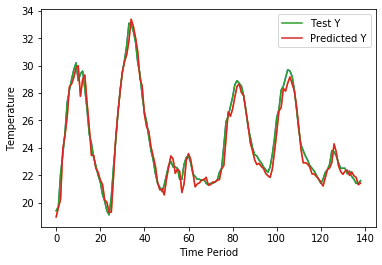

In [6]:
    file_path = './data/'
    file    = '2019_6_Daejeon.csv'
    variables = ["기온(°C)", "풍속(m/s)", 
                 "습도(%)", "해면기압(hPa)", "일시"]

    # Define Hyperparameter
    seq_length = 3
    predict_length = 1
    learning_rate = 0.0005
    iterations = 2000
    data_dim = 4
    hidden_dim = 4
    output_dim = 1

    # Read data & Get variables
    my_data = CSVread(file_path+file, variables)
    temp = my_data[variables[0]]   
    windV = my_data[variables[1]]  
    huminity = my_data[variables[2]]
    pressure = my_data[variables[3]]
    time = my_data[variables[4]]

    Mintemp, Maxtemp = FindMinMax(temp)

    temp = MinMaxScaler(temp)
    windV = MinMaxScaler(windV)
    huminity = MinMaxScaler(huminity)
    pressure = MinMaxScaler(pressure)
    
    # Get Summer Season
    start, end = getStartEnd("2019-06-01 01:00", "2019-06-30 01:00", time)
    summer_temp = np.array(temp[start : end]) 
    summer_windV = np.array(windV[start : end])
    summer_huminity = np.array(huminity[start : end])
    summer_pressure = np.array(pressure[start : end])

    summerLength = end - start + 1
    
    x = np.array([summer_temp, summer_windV, 
                  summer_huminity, summer_pressure])
    x = x.transpose()
    y = summer_temp
    
    testY, test_predict = Model(x, y, summerLength, seq_length, iterations)
    _draw(MinMaxReturn(testY, Mintemp, Maxtemp), 
          MinMaxReturn(test_predict, Mintemp, Maxtemp))
